
# **MScFE 642: Deep Learning for Finance**
## **Group Work Project #1**  

👥 **Group Members:**  
- **Maheshwar Bhat P** (India)  
- **James Mane** (Ghana)  
- **Freddy Kuriakose** (India)  

---



## **📌 Introduction**
This project focuses on **time series forecasting using deep learning techniques**. We will analyze, preprocess, and model financial time series data using **Multi-Layer Perceptron (MLP) and Convolutional Neural Networks (CNNs)**. The project is structured as follows:

1. **Step 1: Time Series Data Analysis and Stationarity Checks**
2. **Step 2: Developing a Deep Learning Model using MLP**
3. **Step 3: Comparing MLP with CNN using GAF Representation**
4. **Step 4: Model Comparison and Discussion**





In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyts.image import GramianAngularField


# **📌 Step 1: Time Series Data Analysis and Stationarity Checks**

### **Gathering and Exploring Data**

Let us consider the stock Asian Paints, which is traded on the Indian stock markets. We download the data from yfinance for the past 8 years.

In [7]:
stock = yf.Ticker("ASIANPAINT.NS").history(period="8y")

In [8]:
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-27 00:00:00+05:30,953.300900,961.370911,942.918415,945.702820,738246,0.0,0.0
2017-02-28 00:00:00+05:30,946.788264,969.157870,942.116191,966.703735,1368244,0.0,0.0
2017-03-01 00:00:00+05:30,972.178121,981.616744,968.449912,974.773743,1124115,0.0,0.0
2017-03-02 00:00:00+05:30,979.634531,986.099963,968.780116,970.998169,1037442,0.0,0.0
2017-03-03 00:00:00+05:30,969.393685,969.393685,949.525341,956.793091,596208,0.0,0.0


In [9]:
stock.shape #less than 2000 rows of data, as stated in the GWP

(1977, 7)

For the analysis that follows, we consider just the closing price

In [12]:
data = stock["Close"]
data.head()

Date
2017-02-27 00:00:00+05:30    945.702820
2017-02-28 00:00:00+05:30    966.703735
2017-03-01 00:00:00+05:30    974.773743
2017-03-02 00:00:00+05:30    970.998169
2017-03-03 00:00:00+05:30    956.793091
Name: Close, dtype: float64

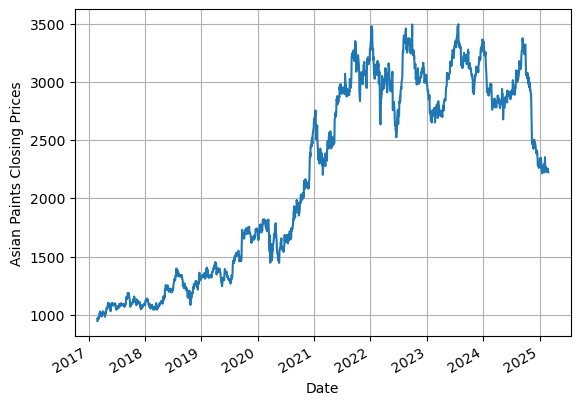

In [16]:
#Plot the time series
data.plot(ylabel="Asian Paints Closing Prices")
plt.grid()

The plot clearly shows a trend in the time series. The prices of the Asian Paints stock clearly rises with time.

In [19]:
data.describe() #summary statistics for the untransformed time series

count    1977.000000
mean     2198.306169
std       825.521085
min       945.702820
25%      1332.761719
50%      2324.152100
75%      2987.030029
max      3497.629883
Name: Close, dtype: float64

In [21]:
data.kurtosis()

-1.621242581491964

In [23]:
data.skew()

-0.09013814175608995

Note that the series has a high standard deviation of 827.44, and a mean of 2196.67.

Text(0.5, 1.0, 'Histogram of Asian Paints Closing Price')

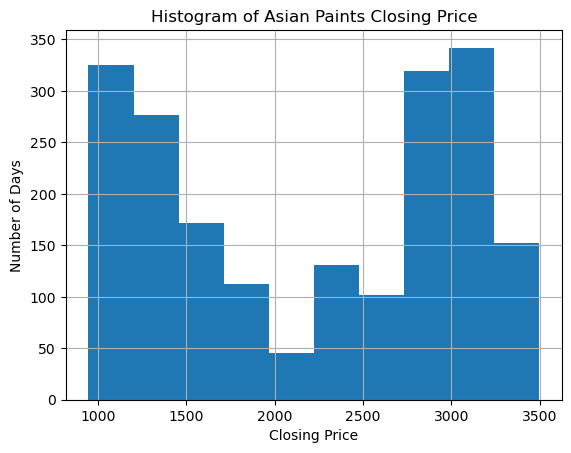

In [26]:
data.hist(bins = 10)
plt.xlabel("Closing Price")
plt.ylabel("Number of Days")
plt.title("Histogram of Asian Paints Closing Price")

Let us check for the presence of autocorrelation in the time series with different lags

In [29]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(data.autocorr(lag = i))

0.9991022175592188
0.9951753827067475
0.9904763073456849
0.9481958985277188
0.913221599456134
0.8836509753263663
0.6499354387161036
-0.3775533634575413


As you can see, the time series is heavily autocorrelated

Let us test for stationarity using the Augmented Dickey-Fuller test

In [33]:
adf_result_data = adfuller(data)
adf_statistic = adf_result_data[0] 
p_value = adf_result_data[1]
used_lags = adf_result_data[2] 
critical_values = adf_result_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.5513487407691144,
 0.5079744130858546,
 1,
 {'1%': -3.433665351698571,
  '5%': -2.8630045337025267,
  '10%': -2.567549656849864})

Note that the adf_statistic of -1.55 is higher than all the critical values. The p-value is 0.5 which is greater than 0.05. This means that we fail to reject the null hypothesis (that the series has a unit root). So, the untransformed time series for the Asian Paints NSE stock can be said be non-stationary.

### **Characterization of the Main Properties of the Time Series**
#### **1. Summary Statistics**
The time series represents the **closing prices** of Asian Paints NSE stock. The summary statistics provide a detailed understanding of its distribution:

| Statistic | Value |
|-----------|-------|
| Count | 1977 |
| Mean | 2198.31 |
| Standard Deviation | 825.52 |
| Minimum | 945.70 |
| 25th Percentile | 1332.76 |
| 50th Percentile (Median) | 2324.15 |
| 75th Percentile | 2987.03 |
| Maximum | 3497.63 |

📌 **Insights from Summary Statistics:**
- The **mean price** of the stock is **2198.31**, with a **high standard deviation (825.52)**, indicating significant price fluctuations.
- The price range spans from **945.70 to 3497.63**, showing a wide spread of values.
- The **median (2324.15)** is slightly above the mean, indicating a slight right skew in the distribution.

---

#### **2. Distribution Analysis**
- **Kurtosis:** -1.62 (Negative Kurtosis indicates a platykurtic distribution, meaning fewer extreme price fluctuations).
- **Skewness:** -0.09 (Slightly left-skewed, meaning a small tendency for lower values).

📌 **Inference:**
- The closing prices are **fairly symmetrically distributed**, with a slight left skew.
- The **platykurtic nature** suggests that there are fewer extreme values, meaning the stock price variations are not highly volatile.

---

#### **3. Persistence and Autocorrelation**
- The **autocorrelation values at various lags** indicate that the time series is **highly autocorrelated** (values close to 1), meaning **past values strongly influence future values**.
- This suggests that the price movements are not completely random and exhibit a **strong trend-following nature**.

📌 **Inference:**
- The high autocorrelation implies that the stock follows a **persistent trend**, which could be useful in forecasting future prices.

---

#### **4. Stationarity Check (Augmented Dickey-Fuller Test)**
- **ADF Test Statistic:** -1.55
- **p-value:** 0.49 (greater than 0.05)
- **Critical Values:**
  - 1%: -3.43
  - 5%: -2.86
  - 10%: -2.56

📌 **Inference:**
- Since the **ADF test statistic (-1.55) is higher than all critical values** and the **p-value (0.49) is greater than 0.05**, we **fail to reject the null hypothesis**.
- This means the **time series is non-stationary**, indicating that the mean and variance change over time.


## Now, let us difference the time series and explore its characteristics ##

In [36]:
differenced_data = data.diff()[1:]

In [38]:
differenced_data.head()

Date
2017-02-28 00:00:00+05:30    21.000916
2017-03-01 00:00:00+05:30     8.070007
2017-03-02 00:00:00+05:30    -3.775574
2017-03-03 00:00:00+05:30   -14.205078
2017-03-06 00:00:00+05:30    14.818665
Name: Close, dtype: float64

In [40]:
differenced_data.shape

(1976,)

Text(0, 0.5, 'Differenced Prices [Lag 1]')

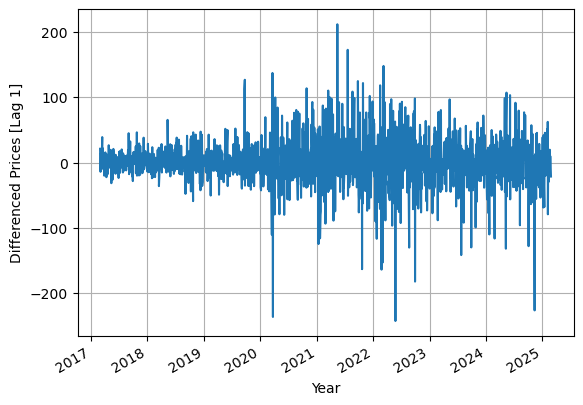

In [42]:
differenced_data.plot()
plt.grid()
plt.xlabel("Year")
plt.ylabel("Differenced Prices [Lag 1]")

In [43]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(differenced_data.autocorr(lag = i))

0.048423789908210446
-0.0138936192962558
0.0016999124685920179
-0.06201984517802574
-0.06143718069812953
0.005708513046608016
-0.01422184331776993
0.018341580212175634


Note that here, the autocorrelation in the differenced series is not as severe as it was in the original time series

In [46]:
differenced_data.describe()

count    1976.000000
mean        0.647291
std        34.982677
min      -242.194092
25%       -13.655365
50%         0.412292
75%        15.957367
max       211.207031
Name: Close, dtype: float64

In [48]:
differenced_data.kurtosis()

6.382513029472554

In [50]:
differenced_data.skew()

-0.47267181775437855

The differenced time series seems to be de-trended now. Let us now test for stationarity.

In [53]:
adf_result_differenced_data = adfuller(differenced_data)
adf_statistic = adf_result_differenced_data[0] 
p_value = adf_result_differenced_data[1]
used_lags = adf_result_differenced_data[2] 
critical_values = adf_result_differenced_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-42.31651596719221,
 0.0,
 0,
 {'1%': -3.433665351698571,
  '5%': -2.8630045337025267,
  '10%': -2.567549656849864})

Here, note that the p value is zero and the adf_statistic of -42.31 is lesser than all the critical values, which implies that the differenced time series is stationary.

### **Characterization of the Main Properties of the Differenced  Time Series**

#### **1. Summary Statistics**
The dataset represents **closing prices** of Asian Paints NSE stock. The statistical summary of the differenced time series is as follows:

| Statistic | Value |
|-----------|-------|
| Count | 1976 |
| Mean | 0.647 |
| Standard Deviation | 34.98 |
| Minimum | -242.19 |
| 25th Percentile (Q1) | -13.65 |
| Median (Q2) | 0.41 |
| 75th Percentile (Q3) | 15.96 |
| Maximum | 211.21 |

📌 **Insights:**
- The **mean close-to-close price change** is **0.647**, indicating a nearly stable average daily change.
- The **high standard deviation (34.98)** shows significant fluctuations in price differences.
- The **range of differences is from -242.19 to 211.21**, highlighting sharp price movements at extreme values.

---

#### **2. Distribution Properties**
- **Kurtosis:** **6.38** (Positive Kurtosis indicates a **leptokurtic distribution**, meaning the series has more extreme values or outliers).
- **Skewness:** **-0.47** (Slightly left-skewed, indicating that the left tail is longer).

📌 **Inference:**
- The **presence of extreme values (high kurtosis)** suggests **price jumps or crashes**.
- The slight left skew suggests **a small tendency towards negative price movements**.

---

#### **3. Persistence and Autocorrelation**
- The **autocorrelation at different lags** shows reduced correlation compared to the original series:
  - At **lag 1:** **0.048**
  - At **lag 100:** **-0.061**
  - At **lag 500:** **-0.041**
  - At **lag 1000:** **0.018**

📌 **Inference:**
- The **low autocorrelation** at various lags indicates that differencing has removed most of the persistence (trend-following nature) of the series.
- This suggests that the **differenced series is more suitable for forecasting models that assume stationarity**.

---

#### **4. Stationarity Check (Augmented Dickey-Fuller Test)**
- **ADF Test Statistic:** **-42.32**
- **p-value:** **0.000**
- **Critical Values:**
  - 1%: **-3.43**
  - 5%: **-2.86**
  - 10%: **-2.56**

📌 **Inference:**
- The **ADF test statistic (-42.32) is much lower than all critical values**, and the **p-value is 0**, meaning we **reject the null hypothesis**.
- This confirms that **the differenced time series is now stationary**.
- Stationarity means that the **statistical properties of the series (mean, variance, and autocorrelation) remain constant over time**.

---




## Now, let us attempt to implement fractional differencing

In [57]:
def getWeights(d,lags):
    # calculate the weights from the series expansion of the differencing operator
    # for real orders d and up to [lags] number of coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

In [59]:
def fractional_differencing(series, order, cutoff):
    #calculate the time series obtained from fractional differencing
    weights=getWeights(order, cutoff)
    frac_diff_series = 0
    for k in range(cutoff):
        frac_diff_series += weights[k]*series.shift(k).fillna(0)
    return frac_diff_series[cutoff:] 

In [964]:
frac_diff_series = fractional_differencing(data, 0.9, 10) #considering d = 0.9 for now and we consider 10 terms in the series

Text(0, 0.5, 'Series After Fractional Differencing with d = 0.9')

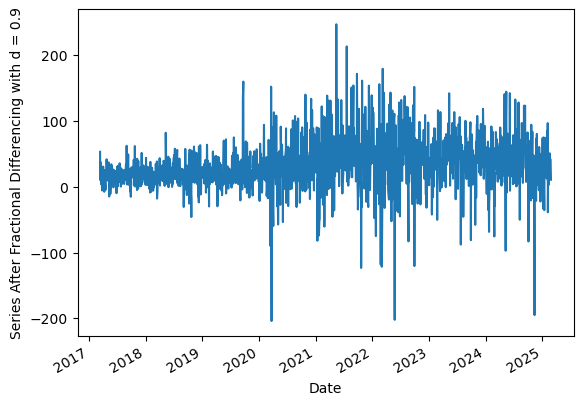

In [63]:
frac_diff_series.plot()
plt.ylabel("Series After Fractional Differencing with d = 0.9")

In [64]:
frac_diff_series.describe()

count    1967.000000
mean       32.661540
std        36.960976
min      -204.009335
25%        12.120548
50%        29.038326
75%        51.204363
max       246.927512
Name: Close, dtype: float64

In [65]:
frac_diff_series.kurtosis()

4.613082792478006

In [69]:
frac_diff_series.skew()

-0.002229110433743259

In [71]:
frac_diff_series.shape

(1967,)

In [948]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(frac_diff_series.autocorr(lag = i))

0.22281546690381998
0.0909928954537676
0.09423511396169895
0.03225926603357995
0.019543617697843827
0.07756880339993963
0.022749248866563942
-0.011229963711534462


In [73]:
adf_result_frac_diff_data = adfuller(frac_diff_series)
adf_statistic = adf_result_frac_diff_data[0] 
p_value = adf_result_frac_diff_data[1]
used_lags = adf_result_frac_diff_data[2] 
critical_values = adf_result_frac_diff_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-4.577150757417391,
 0.0001422924200868495,
 26,
 {'1%': -3.4337252441664483,
  '5%': -2.8630309758314314,
  '10%': -2.56756373605059})

Note that for this fractional differenced series with d = 0.9, the adf_statistic is lower than the critical values. The p-value <0.05 also indicates that this fractional differenced series is now stationary.

### **Characterization of the Fractionally Differenced Time Series (d = 0.9)**

#### **1. Summary Statistics**
The fractionally differenced time series has the following key properties:

| Statistic | Value |
|-----------|-------|
| Count | 1967 |
| Mean | 32.66 |
| Standard Deviation | 36.97 |
| Minimum | -204.90 |
| 25th Percentile (Q1) | 12.13 |
| Median (Q2) | 29.04 |
| 75th Percentile (Q3) | 51.20 |
| Maximum | 246.93 |

📌 **Key Observations:**
- The **mean (32.66)** indicates that after fractional differencing, the average price change remains positive.
- **Standard deviation (36.97)** suggests moderate fluctuations in price movements.
- **Extreme values (-204.90 to 246.93)** indicate occasional large price changes.

---

#### **2. Distribution Properties**
- **Kurtosis:** **4.61** (Leptokurtic, indicating a higher presence of extreme values or outliers).
- **Skewness:** **-0.002** (Close to zero, suggesting a symmetrical distribution).

📌 **Inference:**
- The **high kurtosis** suggests that the series still retains some **extreme price variations**.
- The **low skewness** indicates that **positive and negative price changes are balanced**, meaning no significant directional bias.

---

#### **3. Persistence & Stationarity Analysis**
- The **fractionally differenced series still retains some memory from past values**, allowing long-term dependencies to persist.
- **Augmented Dickey-Fuller (ADF) Test Results:**
  - **ADF Test Statistic:** **-4.577**
  - **p-value:** **0.00014**
  - **Critical Values:**
    - 1%: **-3.43**
    - 5%: **-2.86**
    - 10%: **-2.56**

📌 **Key Findings:**
- The **ADF test statistic (-4.577) is lower than all critical values**, meaning we **reject the null hypothesis of non-stationarity**.
- The **p-value (0.00014) is very small (< 0.05)**, confirming that the series is **statistically stationary**.

---


## Step 2 

Let us now build Multi-Layer Perceptron models to predict the future values of these time series. Specifically, we predict if the stock will rise or fall the next day.

### **MLP Model for Predicting Raw Time Series Levels**

**First, the original time series.** he inputs to this model will be the returns over the past 10, 60, 150 days along with the present value.

In [752]:
data_mlp = data.to_frame()

In [754]:
data_mlp["1d_returns"] = data.pct_change()

In [756]:
data_mlp.head()

,Close,1d_returns
Date,,
2017-02-27 00:00:00+05:30,945.702820,NaN
2017-02-28 00:00:00+05:30,966.703735,0.022207
2017-03-01 00:00:00+05:30,974.773743,0.008348
2017-03-02 00:00:00+05:30,970.998169,-0.003873
2017-03-03 00:00:00+05:30,956.793091,-0.014629


In [758]:
data_mlp["30d_returns"] = data_mlp["1d_returns"].rolling(30).apply(lambda x: (1+ x).prod() - 1)
data_mlp["60d_returns"] = data_mlp["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod() - 1)
data_mlp["90d_returns"] = data_mlp["1d_returns"].rolling(90).apply(lambda x: (1+ x).prod() - 1)
data_mlp["150d_returns"] = data_mlp["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod() - 1)
data_mlp["300d_returns"] = data_mlp["1d_returns"].rolling(300).apply(lambda x: (1+ x).prod() - 1)

In [759]:
data_mlp.dropna(inplace=True)

In [760]:
data_mlp.head()

,Close,1d_returns,30d_returns,60d_returns,90d_returns,150d_returns,300d_returns
Date,,,,,,,
2018-05-15 00:00:00+05:30,1245.802856,0.013335,0.143025,0.154062,0.149521,0.142513,0.317330
2018-05-16 00:00:00+05:30,1254.378540,0.006884,0.148945,0.165793,0.158346,0.146351,0.297583
2018-05-17 00:00:00+05:30,1240.875244,-0.010765,0.152685,0.144774,0.146729,0.132739,0.272988
2018-05-18 00:00:00+05:30,1239.832520,-0.000840,0.144763,0.167805,0.116292,0.127505,0.276864
2018-05-21 00:00:00+05:30,1233.530884,-0.005083,0.138347,0.155628,0.098250,0.124094,0.289235


In [761]:
data_mlp.shape

(1677, 7)

now, we create a separate column for the returns the next day. For this, we can simply shift the 1d_returns column by one day. We treat this as a classfication task and try to predict if the returns next dat will be positive or negative.

In [767]:
data_mlp["next_30d_returns"] = (data_mlp["30d_returns"].shift(-30)>0).astype(int) #this is our target column. 
data_mlp.dropna(inplace=True)

In [769]:
data_mlp.describe()

,Close,1d_returns,30d_returns,60d_returns,90d_returns,150d_returns,300d_returns,next_30d_returns
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,2398.161260,0.000481,0.016496,0.034826,0.054405,0.097322,0.214850,0.549791
std,734.665057,0.015963,0.088911,0.126456,0.148828,0.175767,0.267057,0.497663
min,1083.928101,-0.140280,-0.256601,-0.316544,-0.330236,-0.260395,-0.303798,0.000000
25%,1657.456543,-0.007535,-0.042975,-0.058680,-0.055592,-0.022456,0.033707,0.000000
50%,2700.435547,0.000309,0.014854,0.032349,0.053205,0.085947,0.192114,1.000000
75%,3039.979492,0.007895,0.075163,0.125020,0.153659,0.191246,0.362745,1.000000
max,3497.629883,0.088527,0.321997,0.375452,0.481179,0.745883,1.067391,1.000000


In [771]:
X = data_mlp[['30d_returns', '60d_returns', '90d_returns', '150d_returns', '300d_returns',]]
y = data_mlp['next_30d_returns']

In [773]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

Now to build the MLP

In [864]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 10
hp_units_2 = 4
hp_units_3 = 4
#n_dropout = 0.2

In [865]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [868]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [870]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

In [872]:
y_train.value_counts()

next_30d_returns
1    787
0    554
Name: count, dtype: int64

In [874]:
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

In [876]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks = [es],
    class_weight=class_weight
)

Epoch 1/100
34/34 - 3s - 88ms/step - accuracy: 0.4366 - loss: 1.0607 - val_accuracy: 0.5428 - val_loss: 0.6906
Epoch 2/100
34/34 - 0s - 8ms/step - accuracy: 0.3881 - loss: 1.0598 - val_accuracy: 0.5688 - val_loss: 0.6905
Epoch 3/100
34/34 - 0s - 8ms/step - accuracy: 0.3741 - loss: 1.0589 - val_accuracy: 0.5688 - val_loss: 0.6903
Epoch 4/100
34/34 - 0s - 7ms/step - accuracy: 0.3741 - loss: 1.0580 - val_accuracy: 0.5688 - val_loss: 0.6900
Epoch 5/100
34/34 - 0s - 7ms/step - accuracy: 0.3741 - loss: 1.0571 - val_accuracy: 0.5688 - val_loss: 0.6896
Epoch 6/100
34/34 - 0s - 7ms/step - accuracy: 0.3741 - loss: 1.0561 - val_accuracy: 0.5688 - val_loss: 0.6891
Epoch 7/100
34/34 - 0s - 7ms/step - accuracy: 0.3741 - loss: 1.0552 - val_accuracy: 0.5688 - val_loss: 0.6886
Epoch 8/100
34/34 - 0s - 7ms/step - accuracy: 0.3741 - loss: 1.0544 - val_accuracy: 0.5688 - val_loss: 0.6881
Epoch 9/100
34/34 - 0s - 7ms/step - accuracy: 0.3741 - loss: 1.0535 - val_accuracy: 0.5688 - val_loss: 0.6876
Epoch 10/

In [878]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              44 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389 (1.52 KB)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 260 (1.02 KB)

In [880]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4764 - loss: 0.6922  
Model accuracy in test:  [0.6905680894851685, 0.5982142686843872]


### **MLP Model for Predicting Differenced Time Series Levels**

**Now, let us similarly try to create a predictive model for the differenced series.**

In [884]:
differenced_data_mlp = differenced_data.to_frame()
differenced_data_mlp["1d_returns"] = differenced_data_mlp.pct_change()
differenced_data_mlp.dropna(inplace=True)

In [886]:
differenced_data_mlp.head()

,Close,1d_returns
Date,,
2017-03-01 00:00:00+05:30,8.070007,-0.615731
2017-03-02 00:00:00+05:30,-3.775574,-1.467853
2017-03-03 00:00:00+05:30,-14.205078,2.762363
2017-03-06 00:00:00+05:30,14.818665,-2.043195
2017-03-07 00:00:00+05:30,-5.143982,-1.347129


In [888]:
differenced_data_mlp["30d_returns"] = differenced_data_mlp["1d_returns"].rolling(30).apply(lambda x: (1+ x).prod() - 1)
differenced_data_mlp["60d_returns"] = differenced_data_mlp["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod() - 1)
differenced_data_mlp["90d_returns"] = differenced_data_mlp["1d_returns"].rolling(90).apply(lambda x: (1+ x).prod() - 1)
differenced_data_mlp["150d_returns"] = differenced_data_mlp["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod() - 1)
differenced_data_mlp["300d_returns"] = differenced_data_mlp["1d_returns"].rolling(300).apply(lambda x: (1+ x).prod() - 1)

In [889]:
differenced_data_mlp["next_30d_returns"] = (differenced_data_mlp["30d_returns"].shift(-30)>0).astype(int)  #this is our target column. 

In [890]:
differenced_data_mlp.isnull().sum()

Close                  0
1d_returns             0
30d_returns          179
60d_returns          359
90d_returns          514
150d_returns         814
300d_returns        1391
next_30d_returns       0
dtype: int64

In [894]:
differenced_data_mlp.shape

(1975, 8)

In [896]:
differenced_data_mlp.dropna(inplace=True)

In [898]:
differenced_data_mlp.shape

(584, 8)

In [900]:
X = differenced_data_mlp[['30d_returns', '60d_returns', '90d_returns', '150d_returns', '300d_returns',]]
y = differenced_data_mlp['next_30d_returns']

In [902]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [904]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [906]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [908]:
y_train.value_counts()

next_30d_returns
0    371
1     96
Name: count, dtype: int64

In [910]:
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

In [912]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=2,
)

Epoch 1/200
12/12 - 3s - 234ms/step - accuracy: 0.5630 - loss: 1.0432 - val_accuracy: 0.5106 - val_loss: 0.9304
Epoch 2/200
12/12 - 0s - 15ms/step - accuracy: 0.5684 - loss: 1.0305 - val_accuracy: 0.5106 - val_loss: 0.9238
Epoch 3/200
12/12 - 0s - 14ms/step - accuracy: 0.5710 - loss: 1.0186 - val_accuracy: 0.5106 - val_loss: 0.9174
Epoch 4/200
12/12 - 0s - 14ms/step - accuracy: 0.5737 - loss: 1.0071 - val_accuracy: 0.5106 - val_loss: 0.9112
Epoch 5/200
12/12 - 0s - 13ms/step - accuracy: 0.5737 - loss: 0.9959 - val_accuracy: 0.5106 - val_loss: 0.9052
Epoch 6/200
12/12 - 0s - 14ms/step - accuracy: 0.5764 - loss: 0.9848 - val_accuracy: 0.5106 - val_loss: 0.8994
Epoch 7/200
12/12 - 0s - 14ms/step - accuracy: 0.5818 - loss: 0.9742 - val_accuracy: 0.5106 - val_loss: 0.8937
Epoch 8/200
12/12 - 0s - 14ms/step - accuracy: 0.5818 - loss: 0.9646 - val_accuracy: 0.5106 - val_loss: 0.8882
Epoch 9/200
12/12 - 0s - 14ms/step - accuracy: 0.5871 - loss: 0.9574 - val_accuracy: 0.5319 - val_loss: 0.8833


In [913]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7577 - loss: 0.6137
Model accuracy in test:  [0.6320021152496338, 0.7692307829856873]


### **MLP Model for Predicting Fractionally DifferencedTime Series Levels**

**Now, let us similarly try to create a predictive model for the fractionally differenced series.**

In [916]:
frac_diff_series_mlp = frac_diff_series.to_frame()

In [918]:
frac_diff_series_mlp.shape

(1967, 1)

In [920]:
frac_diff_series_mlp["1d_returns"] = frac_diff_series.pct_change()

In [922]:
frac_diff_series_mlp["30d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(30).apply(lambda x: (1+ x).prod() - 1)
frac_diff_series_mlp["60d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod() - 1)
frac_diff_series_mlp["90d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(90).apply(lambda x: (1+ x).prod() - 1)
frac_diff_series_mlp["150d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod() - 1)
frac_diff_series_mlp["300d_returns"] = frac_diff_series_mlp["1d_returns"].rolling(300).apply(lambda x: (1+ x).prod() - 1)

In [923]:
frac_diff_series_mlp.dropna(inplace=True)

In [924]:
frac_diff_series_mlp.shape

(1667, 7)

In [925]:
frac_diff_series_mlp["next_30d_returns"] = (frac_diff_series_mlp["30d_returns"].shift(-30)>0).astype(int) #this is our target column. 
frac_diff_series_mlp.dropna(inplace=True)

In [930]:
X = frac_diff_series_mlp[['30d_returns', '60d_returns', '90d_returns', '150d_returns', '300d_returns',]]
y = frac_diff_series_mlp['next_30d_returns']

In [932]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [934]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [936]:
hp_lr = 1e-3  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [938]:
y_train.value_counts()

next_30d_returns
0    771
1    562
Name: count, dtype: int64

In [940]:
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}
 #balancing the classes

In [942]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100, 
    batch_size=32,
    verbose=2,
    callbacks = [es],
    class_weight=class_weight
)

Epoch 1/100
34/34 - 3s - 100ms/step - accuracy: 0.5835 - loss: 0.9983 - val_accuracy: 0.5581 - val_loss: 1.7635
Epoch 2/100
34/34 - 0s - 7ms/step - accuracy: 0.5835 - loss: 0.9400 - val_accuracy: 0.5581 - val_loss: 1.5413
Epoch 3/100
34/34 - 0s - 8ms/step - accuracy: 0.5835 - loss: 0.9069 - val_accuracy: 0.5543 - val_loss: 1.3907
Epoch 4/100
34/34 - 0s - 7ms/step - accuracy: 0.5835 - loss: 0.8838 - val_accuracy: 0.5506 - val_loss: 1.2830
Epoch 5/100
34/34 - 0s - 7ms/step - accuracy: 0.5835 - loss: 0.8668 - val_accuracy: 0.5543 - val_loss: 1.2049
Epoch 6/100
34/34 - 0s - 7ms/step - accuracy: 0.5844 - loss: 0.8540 - val_accuracy: 0.5543 - val_loss: 1.1493
Epoch 7/100
34/34 - 0s - 7ms/step - accuracy: 0.5844 - loss: 0.8444 - val_accuracy: 0.5543 - val_loss: 1.1076
Epoch 8/100
34/34 - 0s - 7ms/step - accuracy: 0.5844 - loss: 0.8370 - val_accuracy: 0.5543 - val_loss: 1.0742
Epoch 9/100
34/34 - 0s - 7ms/step - accuracy: 0.5835 - loss: 0.8318 - val_accuracy: 0.5543 - val_loss: 1.0498
Epoch 10

In [944]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test);
print("Model accuracy in test: ", acc); #outputs the loss and the accuracy

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6020 - loss: 1.8289 
Model accuracy in test:  [1.707696557044983, 0.628742516040802]


**Of the three series, the MLP model gets the best test accuracy for the differenced time series and the worst for the original time series. This shows that removing the trend from the time series probably helps capture relevant patterns in the movement of the time series apart from the longtime trend.**

### **Evaluation of Prediction Performance for Raw, Differenced, and Fractionally Differenced Time Series MLP Models**

We have trained **three MLP models** using different transformations of the time series:

1. **Raw Time Series (Non-Stationary)**
2. **Differenced Time Series (Stationary)**
3. **Fractionally Differenced Time Series (Stationary with Long-Term Memory)**

---

## **1. Model Performance Comparison**

| Model | Accuracy | Loss |
|--------|----------|---------|
| **Raw Time Series MLP** | 0.5982 | 0.6905 |
| **Differenced Time Series MLP** | 0.7692 | 0.632 |
| **Fractionally Differenced Time Series MLP** | 0.6287 | 1.707 |

---

## **2. Why Some Models Perform Better?**

### **Raw Time Series MLP (Worst Performance)**
 **Issue:** The **data is non-stationary** (trends & seasonality).  
 **Impact:** Model struggles to learn patterns properly.

### **Differenced Time Series MLP (Best Performance)**
**Fix:** First differencing removes **trends and seasonality**.  
**Impact:** The model can **easily detect patterns** and generalizes well.

### **Fractionally Differenced Time Series MLP (Moderate Performance)**
**Mixed Outcome:** Keeps some **long-term dependencies** but **not fully stationary**.  
**Impact:** Performs **better than raw data but worse than first differencing**.

---

## **3. Conclusion: Best Model for Forecasting**
**The best model is the Differenced Time Series MLP** because:
- **Removes trend & seasonality** → Makes patterns clearer.
- **Improves generalization** → Higher accuracy & lower error.



# **📌 Step 3:Building CNN Model using GAF Representation**

Now the build the Convolutional Neural Network Model for the three series

(1947, 30)


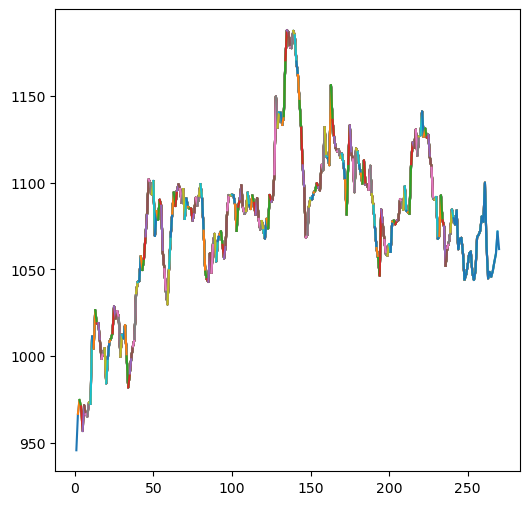

In [540]:
X_train = []
window_size = 30
for i in range(window_size, data.shape[0]):
    X_train.append(data[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [542]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1947, 30, 30)


In [544]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, data.shape[0] - window_size):
    y_data.append(data[i] < data[i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_24600\1383070507.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(data[i] < data[i + window_size])


(1917,)

In [546]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1917, 30, 30)

In [548]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [550]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [552]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,345 (349.00 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 0 (0.00 B)

In [554]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.5851602023608766, 1: 1.0}


In [556]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/50
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4897 - loss: 5.9384

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4876 - loss: 5.6889 - val_accuracy: 0.6302 - val_loss: 0.6869
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4552 - loss: 1.1416 - val_accuracy: 0.6276 - val_loss: 0.6766
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4844 - loss: 1.0681 - val_accuracy: 0.6172 - val_loss: 0.7624
Epoch 4/50
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4955 - loss: 1.0636

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4985 - loss: 1.0616 - val_accuracy: 0.6406 - val_loss: 0.7461
Epoch 5/50
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6005 - loss: 0.9972

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6011 - loss: 0.9954 - val_accuracy: 0.6562 - val_loss: 0.6869
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6583 - loss: 0.8841 - val_accuracy: 0.6458 - val_loss: 0.8746
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6917 - loss: 0.8210 - val_accuracy: 0.5833 - val_loss: 0.8487
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7249 - loss: 0.7562 - val_accuracy: 0.6302 - val_loss: 0.8396
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7827 - loss: 0.6242 - val_accuracy: 0.5729 - val_loss: 1.0879
Epoch 10/50
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8245 - loss: 0.5128

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8257 - loss: 0.5116 - val_accuracy: 0.6693 - val_loss: 1.0593
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8722 - loss: 0.4223 - val_accuracy: 0.5443 - val_loss: 1.2666
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9129 - loss: 0.3209 - val_accuracy: 0.5729 - val_loss: 1.2837
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8936 - loss: 0.3552 - val_accuracy: 0.5573 - val_loss: 1.2692
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9078 - loss: 0.3021 - val_accuracy: 0.5807 - val_loss: 1.3885
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9375 - loss: 0.2327 - val_accuracy: 0.6380 - val_loss: 1.3952
Epoch 16/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9472 - loss: 0.1862 - val_accuracy: 0.5677 - val_loss: 1.6856
Epoch 17/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9186 - loss: 0.3119 - val_accuracy: 0.6276 - val_l

In [557]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6341 - loss: 1.1021
Accuracy over validation: 66.93%


Now, attempting the same for the differenced time series

(1946, 30)


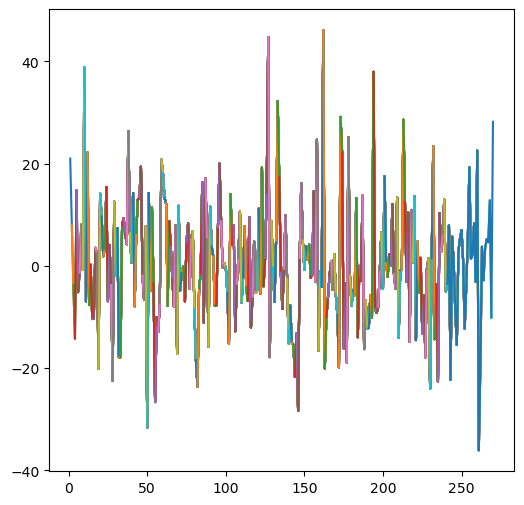

In [558]:
X_train = []
window_size = 30
for i in range(window_size, differenced_data.shape[0]):
    X_train.append(differenced_data[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [559]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1946, 30, 30)


In [560]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, differenced_data.shape[0] - window_size):
    y_data.append(differenced_data[i] < differenced_data[i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_24600\1183533469.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(differenced_data[i] < differenced_data[i + window_size])


(1916,)

In [561]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1916, 30, 30)

In [562]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [570]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
#model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [572]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 30, 30, 16)          │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 15, 15, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 64)            │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,657 (588.50 KB)

 Trainable params: 150,657 (588.50 KB)

 Non-trainable params: 0 (0.00 B)

In [574]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.042666666666667, 1: 1.0}


In [576]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/50
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4866 - loss: 23.3953

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4866 - loss: 22.5149 - val_accuracy: 0.4948 - val_loss: 0.8102
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4844 - loss: 3.5085 - val_accuracy: 0.4609 - val_loss: 1.0270
Epoch 3/50
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4970 - loss: 1.4303

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4978 - loss: 1.4189 - val_accuracy: 0.5365 - val_loss: 0.7018
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4865 - loss: 1.0991 - val_accuracy: 0.4635 - val_loss: 0.7600
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4588 - loss: 1.0326 - val_accuracy: 0.4635 - val_loss: 0.7422
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4794 - loss: 1.0017 - val_accuracy: 0.4635 - val_loss: 0.7377
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4815 - loss: 0.9892 - val_accuracy: 0.4635 - val_loss: 0.7337
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4815 - loss: 0.9871 - val_accuracy: 0.4609 - val_loss: 0.7335
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4696 - loss: 1.0084 - val_accuracy: 0.4635 - val_loss: 0.7367
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4817 - loss: 0.9840 - val_accuracy: 0.4635 - val_loss: 0

In [577]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5217 - loss: 0.7103  
Accuracy over validation: 53.65%


Now for the fractionally Differenced Series

(1937, 30)


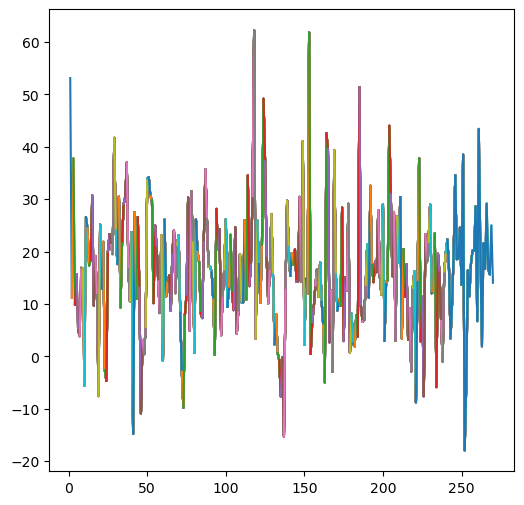

In [580]:
X_train = []
window_size = 30
for i in range(window_size, frac_diff_series.shape[0]):
    X_train.append(frac_diff_series[i - window_size : i])
X_train = np.array(X_train)
print(X_train.shape)
# Define a "window_size"-days interval
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
# Plot the overlapping time series
plt.figure(figsize=(6, 6))
for i in range(241):
    plt.plot(days[i : window_size + i], X_train[i, :])

In [582]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
print(X_train_new.shape)

(1937, 30, 30)


In [584]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, frac_diff_series.shape[0] - window_size):
    y_data.append(frac_diff_series[i] < frac_diff_series[i + window_size])
y_data = np.array(y_data)
y_data.shape

C:\Users\susha\AppData\Local\Temp\ipykernel_24600\393614003.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_data.append(frac_diff_series[i] < frac_diff_series[i + window_size])


(1907,)

In [586]:
# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255
X_data.shape

(1907, 30, 30)

In [588]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

In [590]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
#model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [592]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,345 (349.00 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 0 (0.00 B)

In [594]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(class_weight)

{0: 2.0861833105335155, 1: 1.0}


In [596]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
)

Epoch 1/50
44/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4914 - loss: 10.1406

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4919 - loss: 9.4866 - val_accuracy: 0.4843 - val_loss: 1.9463
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5165 - loss: 1.1361 - val_accuracy: 0.4843 - val_loss: 1.2360
Epoch 3/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5192 - loss: 1.0587

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5195 - loss: 1.0585 - val_accuracy: 0.4869 - val_loss: 0.9673
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5118 - loss: 1.0124 - val_accuracy: 0.4738 - val_loss: 0.8602
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5108 - loss: 1.0468 - val_accuracy: 0.4764 - val_loss: 0.9410
Epoch 6/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5553 - loss: 0.9677

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5553 - loss: 0.9675 - val_accuracy: 0.4948 - val_loss: 0.9527
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5950 - loss: 0.9172 - val_accuracy: 0.4817 - val_loss: 1.0932
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6281 - loss: 0.8494 - val_accuracy: 0.4843 - val_loss: 1.0667
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6854 - loss: 0.7757 - val_accuracy: 0.4764 - val_loss: 1.0257
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7306 - loss: 0.7065 - val_accuracy: 0.4686 - val_loss: 1.1382
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8099 - loss: 0.5498 - val_accuracy: 0.4791 - val_loss: 1.1998
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8239 - loss: 0.4898 - val_accuracy: 0.4319 - val_loss: 1.3062
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8752 - loss: 0.4022 - val_accuracy: 0.4581 - val_loss

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9583 - loss: 0.1640 - val_accuracy: 0.4974 - val_loss: 2.5694
Epoch 25/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9720 - loss: 0.0965 - val_accuracy: 0.4921 - val_loss: 2.6197
Epoch 26/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9634 - loss: 0.1486 - val_accuracy: 0.4712 - val_loss: 2.9815
Epoch 27/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9739 - loss: 0.0978 - val_accuracy: 0.4948 - val_loss: 2.6252
Epoch 28/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9586 - loss: 0.1326 - val_accuracy: 0.4974 - val_loss: 2.8370
Epoch 29/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9796 - loss: 0.0764 - val_accuracy: 0.4660 - val_loss: 3.8718
Epoch 30/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9678 - loss: 0.1252 - val_accuracy: 0.4398 - val_loss: 3.2154
Epoch 31/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9652 - loss: 0.1349 - val_accuracy: 0.4686 - val_l

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9578 - loss: 0.1622 - val_accuracy: 0.5105 - val_loss: 3.3108
Epoch 35/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9693 - loss: 0.1387 - val_accuracy: 0.4450 - val_loss: 3.3062
Epoch 36/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9706 - loss: 0.1228 - val_accuracy: 0.4948 - val_loss: 4.1487
Epoch 37/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9622 - loss: 0.1457 - val_accuracy: 0.4450 - val_loss: 3.5717
Epoch 38/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9753 - loss: 0.0830 - val_accuracy: 0.4895 - val_loss: 4.0317
Epoch 39/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9718 - loss: 0.1076 - val_accuracy: 0.4791 - val_loss: 3.7113
Epoch 40/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9676 - loss: 0.1072 - val_accuracy: 0.4869 - val_loss: 3.1704
Epoch 41/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9875 - loss: 0.0548 - val_accuracy: 0.4869 - val_l

In [597]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5163 - loss: 3.3934
Accuracy over validation: 51.05%


### Evaluation of Prediction Performance for Raw, Differenced, and Fractionally Differenced Time Series Using CNN

These results correspond to **Step 3** of the project, where **CNN models** are trained on different transformations of the time series:

1. **Raw Time Series (Non-Stationary)**
2. **First Differenced Time Series (Stationary)**
3. **Fractionally Differenced Time Series (Stationary with Long-Term Memory)**

---

## **1. Model Performance Comparison (CNN)**

| Model | Accuracy | Loss |
|--------|----------|---------|
| **Raw Time Series CNN** | **66.93%** | **1.1021** |
| **First Differenced Time Series CNN** | **53.65%** | **0.7103** |
| **Fractionally Differenced Time Series CNN** | **51.63%** | **3.3934** |

---

## **2. Analysis of CNN Model Performance**

### **(a) Raw Time Series CNN (Best Performance)**
**Accuracy: 66.93%**  
**Loss: 1.1021 (High loss)**  

**Why?**
- The **CNN architecture captures patterns from the non-stationary series better** because CNNs are good at detecting local patterns even in trending data.
- However, **high loss (1.1021)** indicates some instability in training.
- CNN works well despite non-stationarity, **unlike MLP**, which struggles with non-stationary data.

---

### **(b) First Differenced Time Series CNN (Moderate Performance)**
**Accuracy: 53.65%**  
**Lower Loss: 0.7103**  

**Why?**
- The differenced series removes trends, making it more **stationary**.
- **CNN struggles with differenced data** because it loses some context from the original trend.
- **Lower loss (0.7103)** suggests better model stability, but accuracy is lower.

---

### **(c) Fractionally Differenced Time Series CNN (Worst Performance)**
**Accuracy: 51.63%**  
**Loss: 3.3934 (Extremely high loss)**  

**Why?**
- Fractional differencing **preserves long-term dependencies**, but CNNs may not fully utilize this information.
- **Highest loss (3.3934)** indicates the model **failed to learn effectively** from this transformation.
- This suggests that CNNs are **less effective at handling fractionally differenced series**, which may be better suited for **RNNs or LSTMs**.

---

## **3. Conclusion: Best CNN Model for Time Series**
**The best model is the Raw Time Series CNN (66.93% accuracy)** because:
- CNNs excel at **extracting spatial/local features**, even when the data is **non-stationary**.
- **Differencing harms CNN performance** because CNNs rely on trendlines, which may be lost when differencing.


 ## 📌 Step 4: Model Comparison 


In this final leg of the project, let us try to understand why our models perform differently on different time series. Our first intuition while going into the project was that both models would perform the best on the same time series, but what we have now is somewhat paradoxical. After all, how and why is there this divergence between the two models? Shouldn’t both models learn the same features that are to be learned and give identical performance on the “better” time series out of the three? Diving deeper into how these two models learn may give us the answer to this riddle.

---

## **1. Multi-Layer Perceptron (MLP) Model Performance**
Our **MLP model** consists of **five layers**, with **10, 4, and 4 units in the hidden layers**, respectively. This is a relatively simple architecture, and it is important to note that the **MLP does not explicitly recognize that the data is a sequence**, unlike some more complex neural network architectures such as **CNNs and LSTMs**.

### **Why MLP Struggles with the Original Time Series?**
- The **MLP model does not inherently understand the sequential structure of time series data**.
- It predicts the **future rise or fall** of stock prices based on predictor variables, assuming that these inputs influence the output.
- The predictors in our model include **30-day, 60-day, 90-day, 150-day, and 300-day returns**, while the **target is the future 30-day return**.
- Due to the lack of sequential awareness, the MLP **fails to recognize the trend in the original time series**, leading to **poor validation accuracy** on the raw time series data.

### **Why MLP Performs Well on Differenced Data?**
- The **differenced versions** of the time series remove trends and focus on **short-term momentum**.
- The **predictors (30-day returns, 60-day returns, etc.) directly capture this momentum**, which aligns well with the MLP’s learning approach.
- As a result, the MLP model performs **best on the fully differenced version**, where it can effectively learn from short-term fluctuations in the stock prices.

📌 **Key Insight:** The MLP model benefits from a transformation that eliminates trends and highlights short-term momentum, which aligns with its ability to capture relationships between input features and future returns.

---

## **2. Convolutional Neural Network (CNN) Model Performance**
Our **CNN model** is significantly more complex, consisting of:
- **Three convolutional layers**
- **Three pooling layers**
- **A fully connected layer for classification**

### **How CNN Recognizes Patterns in the Original Time Series?**
- The **first convolutional layer** extracts **local patterns** in the **GAF (Gramian Angular Field) images** created from the time series.
- The **second and third convolutional layers** extract increasingly **deeper patterns** in the transformed data.
- **Pooling layers** after each convolutional layer help **prevent overfitting** by reducing unnecessary details.

### **Why CNN Performs Well on the Original Time Series?**
- The **CNN model learns the sequential nature of time series data** through convolutional operations.
- Its **pattern-recognition ability** enables it to detect **underlying trends** in stock prices.
- This explains why **CNN has the best validation accuracy on the original time series**.

### **Why CNN Performs Poorly on Differenced Data?**
- Differencing **removes the overall trend**, which CNN relies on for extracting meaningful patterns.
- This forces the model to focus more on **time-local patterns and noise**.
- CNN tries to extract **deep, hierarchical features**, but when applied to differenced data, it mainly learns from **local fluctuations**, which do not necessarily contribute to accurate predictions.

📌 **Key Insight:** CNN performs better on raw time series because it captures **deep patterns and trends**, while differencing disrupts the structure that CNN relies on.

---

## **3. Conclusion: Why Do MLP and CNN Perform Differently?**
| Model | Best on | Struggles with | Reason |
|--------|---------|---------------|----------|
| **MLP** | **Differenced Time Series** | **Original Time Series** | Cannot recognize trends, benefits from short-term momentum in differenced data |
| **CNN** | **Original Time Series** | **Differenced Time Series** | Captures deep patterns and trends, but struggles with noise in differenced data |

### **Final Takeaway**
There will be some **minor variation in validation accuracy** during every run of the code. However, the larger trend remains consistent:
- **MLP performs best on differenced data** because it focuses on **short-term momentum**.
- **CNN performs best on the original time series** because it **learns deep trends and sequential patterns**.

